<a href="https://colab.research.google.com/github/ejlee127/sound-learning/blob/main/train_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 252 kB in 2s (149 kB/s)
Reading package lists... Done


In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-11-04 18:29:40--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.40MB/s    in 0.6s    

2020-11-04 18:29:41 (1.40 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [4]:
import numpy as np
import json
# Read in data from S3 Buckets
from pyspark import SparkFiles

def pulljsonFiles(filename):
  json_url="https://billdatavizclass.s3.amazonaws.com/" + filename
  spark.sparkContext.addFile(json_url)
  data= spark.read.option('multiline','true').json(SparkFiles.get(filename))

  # return the data from the file
  inputsTmp = data.select("mfcc").collect()
  inputs = inputsTmp[0][0] #  
  targetsTmp = data.select("classID").collect()
  targets = targetsTmp[0][0]

  return inputs,targets



In [5]:
def createSet(inputs,targets,currentSet=[], currentTarget=[]):

  for i in range(len(inputs)):
      currentSet.append(inputs[i])
      currentTarget.append(targets[i])
  return currentSet, currentTarget

In [63]:
fileList = ["data1.json","data2.json","data3.json","data4.json","data5.json","data6.json","data7.json","data8.json","data9.json","data10.json"]
testList = ["data10.json","data5.json", "data1.json"]
X_test = []
X_train = []
y_test = []
y_train = []

for file in fileList:
  inputs, targets = pulljsonFiles(file)
  print(np.shape(inputs))
  if file in testList: X_test, y_test = createSet(inputs,targets,X_test, y_test)
  else: X_train, y_train = createSet(inputs,targets,X_train, y_train)
  print(f"done with file: {file}")
print("shape",np.shape(X_train))
print("shape",np.shape(X_test))
X_test = np.array(X_test)
X_train = np.array(X_train)
y_test = np.array(y_test)
y_train = np.array(y_train)

(3106, 44, 13)
done with file: data1.json
(3076, 44, 13)
done with file: data2.json
(3337, 44, 13)
done with file: data3.json
(3454, 44, 13)
done with file: data4.json
(3248, 44, 13)
done with file: data5.json
(2901, 44, 13)
done with file: data6.json
(3010, 44, 13)
done with file: data7.json
(2809, 44, 13)
done with file: data8.json
(2910, 44, 13)
done with file: data9.json
(2974, 44, 13)
done with file: data10.json
shape (21497, 44, 13)
shape (9328, 44, 13)


In [64]:
print(X_train.shape[0],X_train.shape[1], X_train.shape[2])
print(y_train.shape[0], y_train.shape[1])
print(X_test.shape[0],X_test.shape[1], X_test.shape[2])
print(y_test.shape[0], y_test.shape[1])


21497 44 13
21497 1
9328 44 13
9328 1


In [65]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [66]:
keras.backend.clear_session()

In [67]:
# build the network architecture
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # lst hidden layer
    keras.layers.Dense(512, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 2nd hidden layer
    keras.layers.Dense(512, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 3rd hidden layer
    keras.layers.Dense(512, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # output layer
    keras.layers.Dense(10, activation="softmax")
])

In [68]:
# compile network : example
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',
             loss = "sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 572)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               293376    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [69]:
# train network
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

## overfitting -- identify

Epoch 1/50
672/672 [==============================] - 9s 13ms/step - loss: 5.1778 - accuracy: 0.3707 - val_loss: 3.1203 - val_accuracy: 0.4143
Epoch 2/50
672/672 [==============================] - 9s 13ms/step - loss: 2.7694 - accuracy: 0.4671 - val_loss: 2.9148 - val_accuracy: 0.4405
Epoch 3/50
672/672 [==============================] - 9s 13ms/step - loss: 2.4946 - accuracy: 0.5061 - val_loss: 2.8754 - val_accuracy: 0.4327
Epoch 4/50
672/672 [==============================] - 9s 13ms/step - loss: 2.2972 - accuracy: 0.5226 - val_loss: 2.6241 - val_accuracy: 0.4578
Epoch 5/50
672/672 [==============================] - 9s 13ms/step - loss: 2.0976 - accuracy: 0.5469 - val_loss: 2.5248 - val_accuracy: 0.4383
Epoch 6/50
672/672 [==============================] - 9s 13ms/step - loss: 1.9641 - accuracy: 0.5512 - val_loss: 2.5560 - val_accuracy: 0.4773
Epoch 7/50
672/672 [==============================] - 9s 13ms/step - loss: 1.8497 - accuracy: 0.5623 - val_loss: 2.6022 - val_accuracy: 0.4632

In [31]:
import matplotlib.pyplot as plt

def plot_history(history):
  fig, axs = plt.subplots(2)

  #create the accuracy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")
  axs[0].set_title("accuracy eval")

  # create accuracy
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="best")
  axs[1].set_title("Error eval")

  plt.show()

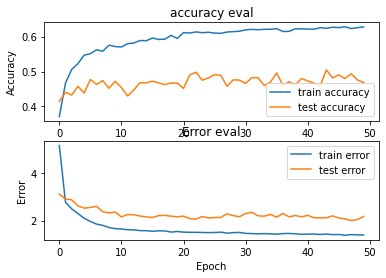

In [70]:
plot_history(model_history)

In [71]:
# Save the model
model.save("sound_model_trained.h5")

In [72]:
model_loss, model_accuracy = model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

292/292 - 1s - loss: 2.1765 - accuracy: 0.4687
Normal Neural Network - Loss: 2.1765217781066895, Accuracy: 0.46869638562202454
